In [1]:
import os
from run_deep_dropout_gpu import train_eval
from test_deep_gpu import test
import time
import argparse
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

run deep gpu py with dropout
cpu
run deep gpu py
cpu


In [2]:
reward_week1 = open('./deep/reward20190602-104715_dropout.txt','r')
reward_week2 = open('./deep/reward20190602-105535_dropout.txt','r')
reward_week3 = open('./deep/reward20190602-105538_dropout.txt','r')
reward_1 = []
reward_2 = []
reward_3 = []
for r in reward_week1:
    reward_1.append(float(r[7:-3])/25)
for r in reward_week2:
    reward_2.append(float(r[7:-3])/25)
for r in reward_week3:
    reward_3.append(float(r[7:-3])/25)

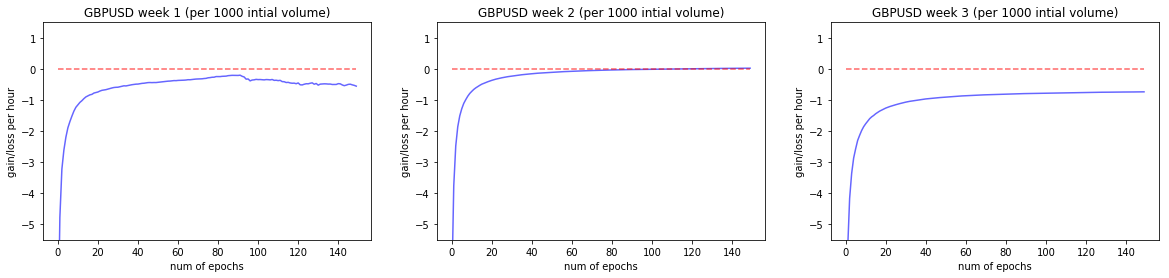

In [3]:
cur = 'GBPUSD'
plt.rcParams['figure.figsize'] = [20, 4]
epochs = range(0 ,150, 1)
breakeven = [0]*150
rewards = [reward_1, reward_2, reward_3]
fig = plt.figure()
gs = gridspec.GridSpec(1, 3)
for n in range(3):
    title = cur + " week " + str(n+1) + ' (per 1000 intial volume)'
    ax = fig.add_subplot(gs[0, n]) 
    ax.plot(epochs, rewards[n], 'b', epochs, breakeven, 'r--', alpha = 0.6)
    ax.set(xlabel='num of epochs', ylabel='gain/loss per hour')
    ax.set_title(title)
    ax.set_ylim(-5.5, 1.5)

In [72]:
cur = 'EURUSD'
week_num = 2
HOURLY_RF_RATE = 2.68 * 10 / 365.0 / 24.0

if week_num == 1:
    reward_file = './deep/reward20190602-055412_dropout.txt'
    model_path = './deep/best_model_EURUSD_week1_20190602-055445_dropout.pth'
if week_num == 2:
    reward_file = './deep/reward20190602-064038_dropout.txt'
    model_path = './deep/best_model_EURUSD_week2_20190602-064117_dropout.pth'
if week_num == 3:
    reward_file = './deep/reward20190602-055515_dropout.txt'
    model_path = './deep/best_model_EURUSD_week3_20190602-055548_dropout.pth'
class Config():
    def __init__(self):
        self.mode = 'train_eval'
        self.save = 'RLFX'
        self.reward_file = reward_file
        self.currency = cur
        self.min_history = 1000
        self.timespan = 3600
        self.lag = 16
        self.num_of_eval = 25
        self.init_lr = 1e-1
        self.num_of_epoch = 150
        self.num_of_episode = 25
        self.week_num = week_num
        self.model_path = model_path
        self.offset = 300
        self.num_of_test = 50
config = Config()

T = 3617
evalname = './data_drl/eval_' + cur + '_lag_16_week' + str(config.week_num) + '.csv'
_eval= pd.read_csv(evalname).reset_index(drop = True)
to_draw_eval = np.sort(_eval['timestamp'].unique())
num_of_hour = round(to_draw_eval.shape[0]/3600,0)
print(to_draw_eval.shape[0]/3600)

def draw_eval_episode(week_num, lag, cur, min_history, factor, offset):
    n = (factor * 3600) % int(to_draw_eval.shape[0]- min_history) + offset
    _max = to_draw_eval.shape[0]
    _end = min(n+T, _max)
    timeframe = to_draw_eval[n:_end]
    eval = _eval[_eval.timestamp.isin(timeframe)]
    target_bid = eval['bid price'].values
    target_ask = eval['ask price'].values
    feature_span = eval.iloc[:,-lag*8*2:].values
    normalized = (feature_span-feature_span.mean())/feature_span.std()
    return torch.tensor(target_bid).to(device), \
           torch.tensor(target_ask).to(device), \
           torch.tensor(normalized).to(device)
def test(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    policy = Policy()
    if torch.cuda.is_available():
        policy.load_state_dict(torch.load(config.model_path))
    else:
        policy.load_state_dict(torch.load(config.model_path, map_location='cpu'))
    policy.to(device)
    policy.eval()
#     d = {'bid_price': [0], 'ask_price': [0], 'action':[0]}
#     df = pd.DataFrame(data=d)
    rewards_over_time = []
    with torch.no_grad():
        accumulative_reward_test = 0
        print_reward = []
        print_action = []
        for j in range(min(config.num_of_test,int(num_of_hour))):
            print(j)
            current_reward = 0
            current_action = 0
            ask = np.zeros((1, 1))
            bid = np.zeros((1, 1))
            previous_action = torch.tensor([0.0]).to(device)
#             while ask.shape[0] <= config.timespan and bid.shape[0]<=3600:
            target_bid, target_ask, feature_span = draw_eval_episode(config.week_num, config.lag,config.currency,
                                                                         config.min_history, j, config.offset)
            bid, ask, feature_span = target_bid*1e3, target_ask*1e3, feature_span
            for t in range(config.timespan):  
                state = feature_span[t]
                save_action = policy(state.float(),0.1*previous_action).to(device)
                if t == config.timespan-1:
                    save_action = 0
                action = save_action - previous_action
                price = 0
                if action > 0:
                    price = ask[t]
                elif action < 0:
                    price = bid[t]
                reward = torch.sum(torch.tensor(-1.).float() * action * price).to(device)
                accumulative_reward_test += reward
                current_reward  += reward
                current_action += save_action
#                 d = {'bid_price': [bid[t]], 'ask_price': [ask[t]], 'action':[action.item()]}
#                 temp_df = pd.DataFrame(data=d)
#                 df = df.append(temp_df)
                previous_action = save_action
            print_reward.append(current_reward)
            print_action.append(current_action/3600)
            print ("episode_reward {} episode_action {}".format(current_reward.item(), 
                                                                (current_action/3600)[0].item()))
#         reward_np = np.array(print_reward)
#         std = np.std(reward_np)
#         sharpe_ratio = (np.mean(reward_np) - HOURLY_RF_RATE) / std
        print ("Testing on {} datapoint and return is {}".format(min(config.num_of_test,int(num_of_hour)),
                                                                 accumulative_reward_test))
#         print("Mean {} std {} sharpe ratio {}".format(mean,std, sharpe_ratio))
#         rewards_over_time.append(accumulative_reward_test)   
#     saved_path = 'deep/result/' + config.currency + '_week_' + str(config.week_num) +'.csv'
#     print('Saving the csv file ...')
#     df.to_csv(saved_path, index = False)
    return print_reward, print_action

46.793055555555554


In [73]:
print_reward, print_action = test(config)

0
episode_reward -0.3270263671875 episode_action -0.9820944666862488
1
episode_reward -0.460205078125 episode_action -0.9842095971107483
2
episode_reward -0.00634765625 episode_action -0.9843986630439758
3
episode_reward -0.3720703125 episode_action -0.9841395616531372
4
episode_reward 0.003662109375 episode_action -0.9826639890670776
5
episode_reward -0.0308837890625 episode_action -0.984444797039032
6
episode_reward 0.5394287109375 episode_action -0.9838401079177856
7
episode_reward 0.794189453125 episode_action -0.985360324382782
8
episode_reward -1.2725830078125 episode_action -0.9822481274604797
9
episode_reward 0.7559814453125 episode_action -0.9847584962844849
10
episode_reward 0.11181640625 episode_action -0.984241783618927
11
episode_reward -0.7254638671875 episode_action -0.9846413731575012
12
episode_reward 1.382080078125 episode_action -0.9845408797264099
13
episode_reward 1.687255859375 episode_action -0.9849994778633118
14
episode_reward -1.162841796875 episode_action -0.

IndexError: index 2555 is out of bounds for dimension 0 with size 2555